In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_ta as ta # pip install pandas-ta
import yfinance as yf # pip install yfinance
import matplotlib.dates as mdates
from scipy import stats

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [351]:
listings = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIA']

# Acquiring data from yfinance

This code will acquire the historical stock price and dividend information from the Yahoo Finance API and export it to CSV. This is also accomplished by data_collection.py within the repo.  
The code has been commented out as to not re-download old data, or to download new data.

In [352]:
#df = yf.download(tickers=listings, period='10y', interval='1d', auto_adjust=False)

In [353]:
"""
# stack and unstack indexed columns
df = df.stack(level=0).unstack(level=1)

# set each column name to TICKER - VALUE
df.columns = df.columns.map(lambda x: f'{x[0]} - {x[1]}')

# create date column from index
df = df.reset_index()
df = df.rename(columns={'index': 'Date'})
"""

"\n# stack and unstack indexed columns\ndf = df.stack(level=0).unstack(level=1)\n\n# set each column name to TICKER - VALUE\ndf.columns = df.columns.map(lambda x: f'{x[0]} - {x[1]}')\n\n# create date column from index\ndf = df.reset_index()\ndf = df.rename(columns={'index': 'Date'})\n"

In [354]:
"""
for ticker in listings:
    col_name = f'{ticker} - Dividend'
    div_series = yf.Ticker(ticker).dividends
    series_df = div_series.to_frame(name=col_name)
    series_df.index = series_df.index.tz_convert(None).floor('D')
    df = pd.merge(df, series_df, left_on='Date', right_index=True, how='left')
    df[col_name] = df[col_name].fillna(0)
"""

"\nfor ticker in listings:\n    col_name = f'{ticker} - Dividend'\n    div_series = yf.Ticker(ticker).dividends\n    series_df = div_series.to_frame(name=col_name)\n    series_df.index = series_df.index.tz_convert(None).floor('D')\n    df = pd.merge(df, series_df, left_on='Date', right_index=True, how='left')\n    df[col_name] = df[col_name].fillna(0)\n"

In [355]:
#df.to_csv('dija_w_divs.csv', index=False)

# Pre processing data

In [356]:
df = pd.read_csv('djia_data.csv')

In [357]:
stock = 'AAPL'
stock_cols = [col for col in df.columns if col.startswith(f'{stock} -')]

In [358]:
stock_cols = stock_cols + ['Date']

In [359]:
df[df['Date'] > '2020-02'][['Date', 'AAPL - Close', 'AAPL - Dividend']].head(50)

,Date,AAPL - Close,AAPL - Dividend
4186,2020-02-03,77.165001,0.0000
4187,2020-02-04,79.712502,0.0000
4188,2020-02-05,80.362503,0.0000
4189,2020-02-06,81.302498,0.0000
4190,2020-02-07,80.007500,0.1925
4191,2020-02-10,80.387497,0.0000
4192,2020-02-11,79.902496,0.0000
4193,2020-02-12,81.800003,0.0000
4194,2020-02-13,81.217499,0.0000
4195,2020-02-14,81.237503,0.0000


In [360]:
for stock in listings:
    stock_df = pd.DataFrame()

    # feature engineering
    stock_df[f'{stock} - RSI14'] = ta.rsi(df[f'{stock} - Close'], length=14)
    stock_df[f'{stock} - RSI5'] = ta.rsi(df[f'{stock} - Close'], length=5)
    stock_df[f'{stock} - EMA5'] = ta.ema(df[f'{stock} - Close'], length=5)
    stock_df[f'{stock} - EMA15'] = ta.ema(df[f'{stock} - Close'], length=15)
    stock_df[f'{stock} - EMA50'] = ta.ema(df[f'{stock} - Close'], length=50)
    macd_short = ta.ema(df[f'{stock} - Close'], length=12)
    macd_long = ta.ema(df[f'{stock} - Close'], length=26)
    stock_df[f'{stock} - MACD'] = macd_short - macd_long
    stock_df[f'{stock} - MACD_signal'] = ta.ema(stock_df[f'{stock} - MACD'], length=9)
    stock_df[f'{stock} - MACD_div'] = stock_df[f'{stock} - MACD'] - stock_df[f'{stock} - MACD_signal']

    # target engineering
    stock_df[f'{stock} - 1week_close'] = df[f'{stock} - Close'].shift(-5)
    stock_df[f'{stock} - Pct_change_wk'] = (stock_df[f'{stock} - 1week_close']/df[f'{stock} - Close'] - 1) * 100
    stock_df[f'{stock} - Wk_change_binary'] = stock_df[f'{stock} - Pct_change_wk'].apply(lambda x: 1 if x > 2 else 0)
    stock_df[f'{stock} - Wk_change'] = stock_df[f'{stock} - Pct_change_wk'].apply(lambda x: 0 if x < -5 else (1 if -5 < x < 0 else (2 if 0 < x < 5 else 3)))

    # Days till dividend
    stock_df[f'{stock} - Days_till_div'] = 0
    nonzero_div_indices = df[df[f'{stock} - Dividend'] != 0].index
    if(len(nonzero_div_indices) > 0):
        start_idx = 0
        end_idx = nonzero_div_indices[0]
        stock_df.loc[start_idx+1:end_idx, f'{stock} - Days_till_div'] = end_idx - df.index[start_idx:end_idx].values
        for i in range(len(nonzero_div_indices) - 1):
            start_idx = nonzero_div_indices[i]
            end_idx = nonzero_div_indices[i + 1]
            stock_df.loc[start_idx+1:end_idx, f'{stock} - Days_till_div'] = end_idx - df.index[start_idx:end_idx].values
    
    df = df.join(stock_df)

df = df.reindex()

In [361]:
df['Date'] = pd.to_datetime(df['Date'])

## Cyclic encoding of dates  
The day of the week, day of the month, and month will all be cyclic encoded in order to retain the cyclic nature of these variables to the LSTM for modeling.  
The year will not be cyclic encoded as it is strictly increasing.

In [362]:
# extract int representation of date
df['Year'] = df['Date'].dt.year.astype(int)
df['Month'] = df['Date'].dt.month.astype(int)
df['Day'] = df['Date'].dt.day.astype(int)
df['Weekday'] = df['Date'].dt.dayofweek.astype(int)

In [363]:
df.loc[:, 'Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 5)
df.loc[:, 'Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 5)

df.loc[:, 'Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df.loc[:, 'Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

df.loc[:, 'Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df.loc[:, 'Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

#df = df.drop(columns=['Day', 'Month', 'Weekday'])

# EDA

## Correlation

In [364]:
correlation_table = []

for stock in listings:
    target = f'{stock} - Pct_change_wk'
    cols = [col for col in df.columns if col.startswith(f'{stock} - ')]

    cols = cols + ['Weekday_sin', 'Weekday_cos', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos', 'Year']

    correlation_matrix = df[cols].corr()
    correlation_with_target = correlation_matrix[target].abs().sort_values(ascending=False)
    correlation_table.append(correlation_with_target)

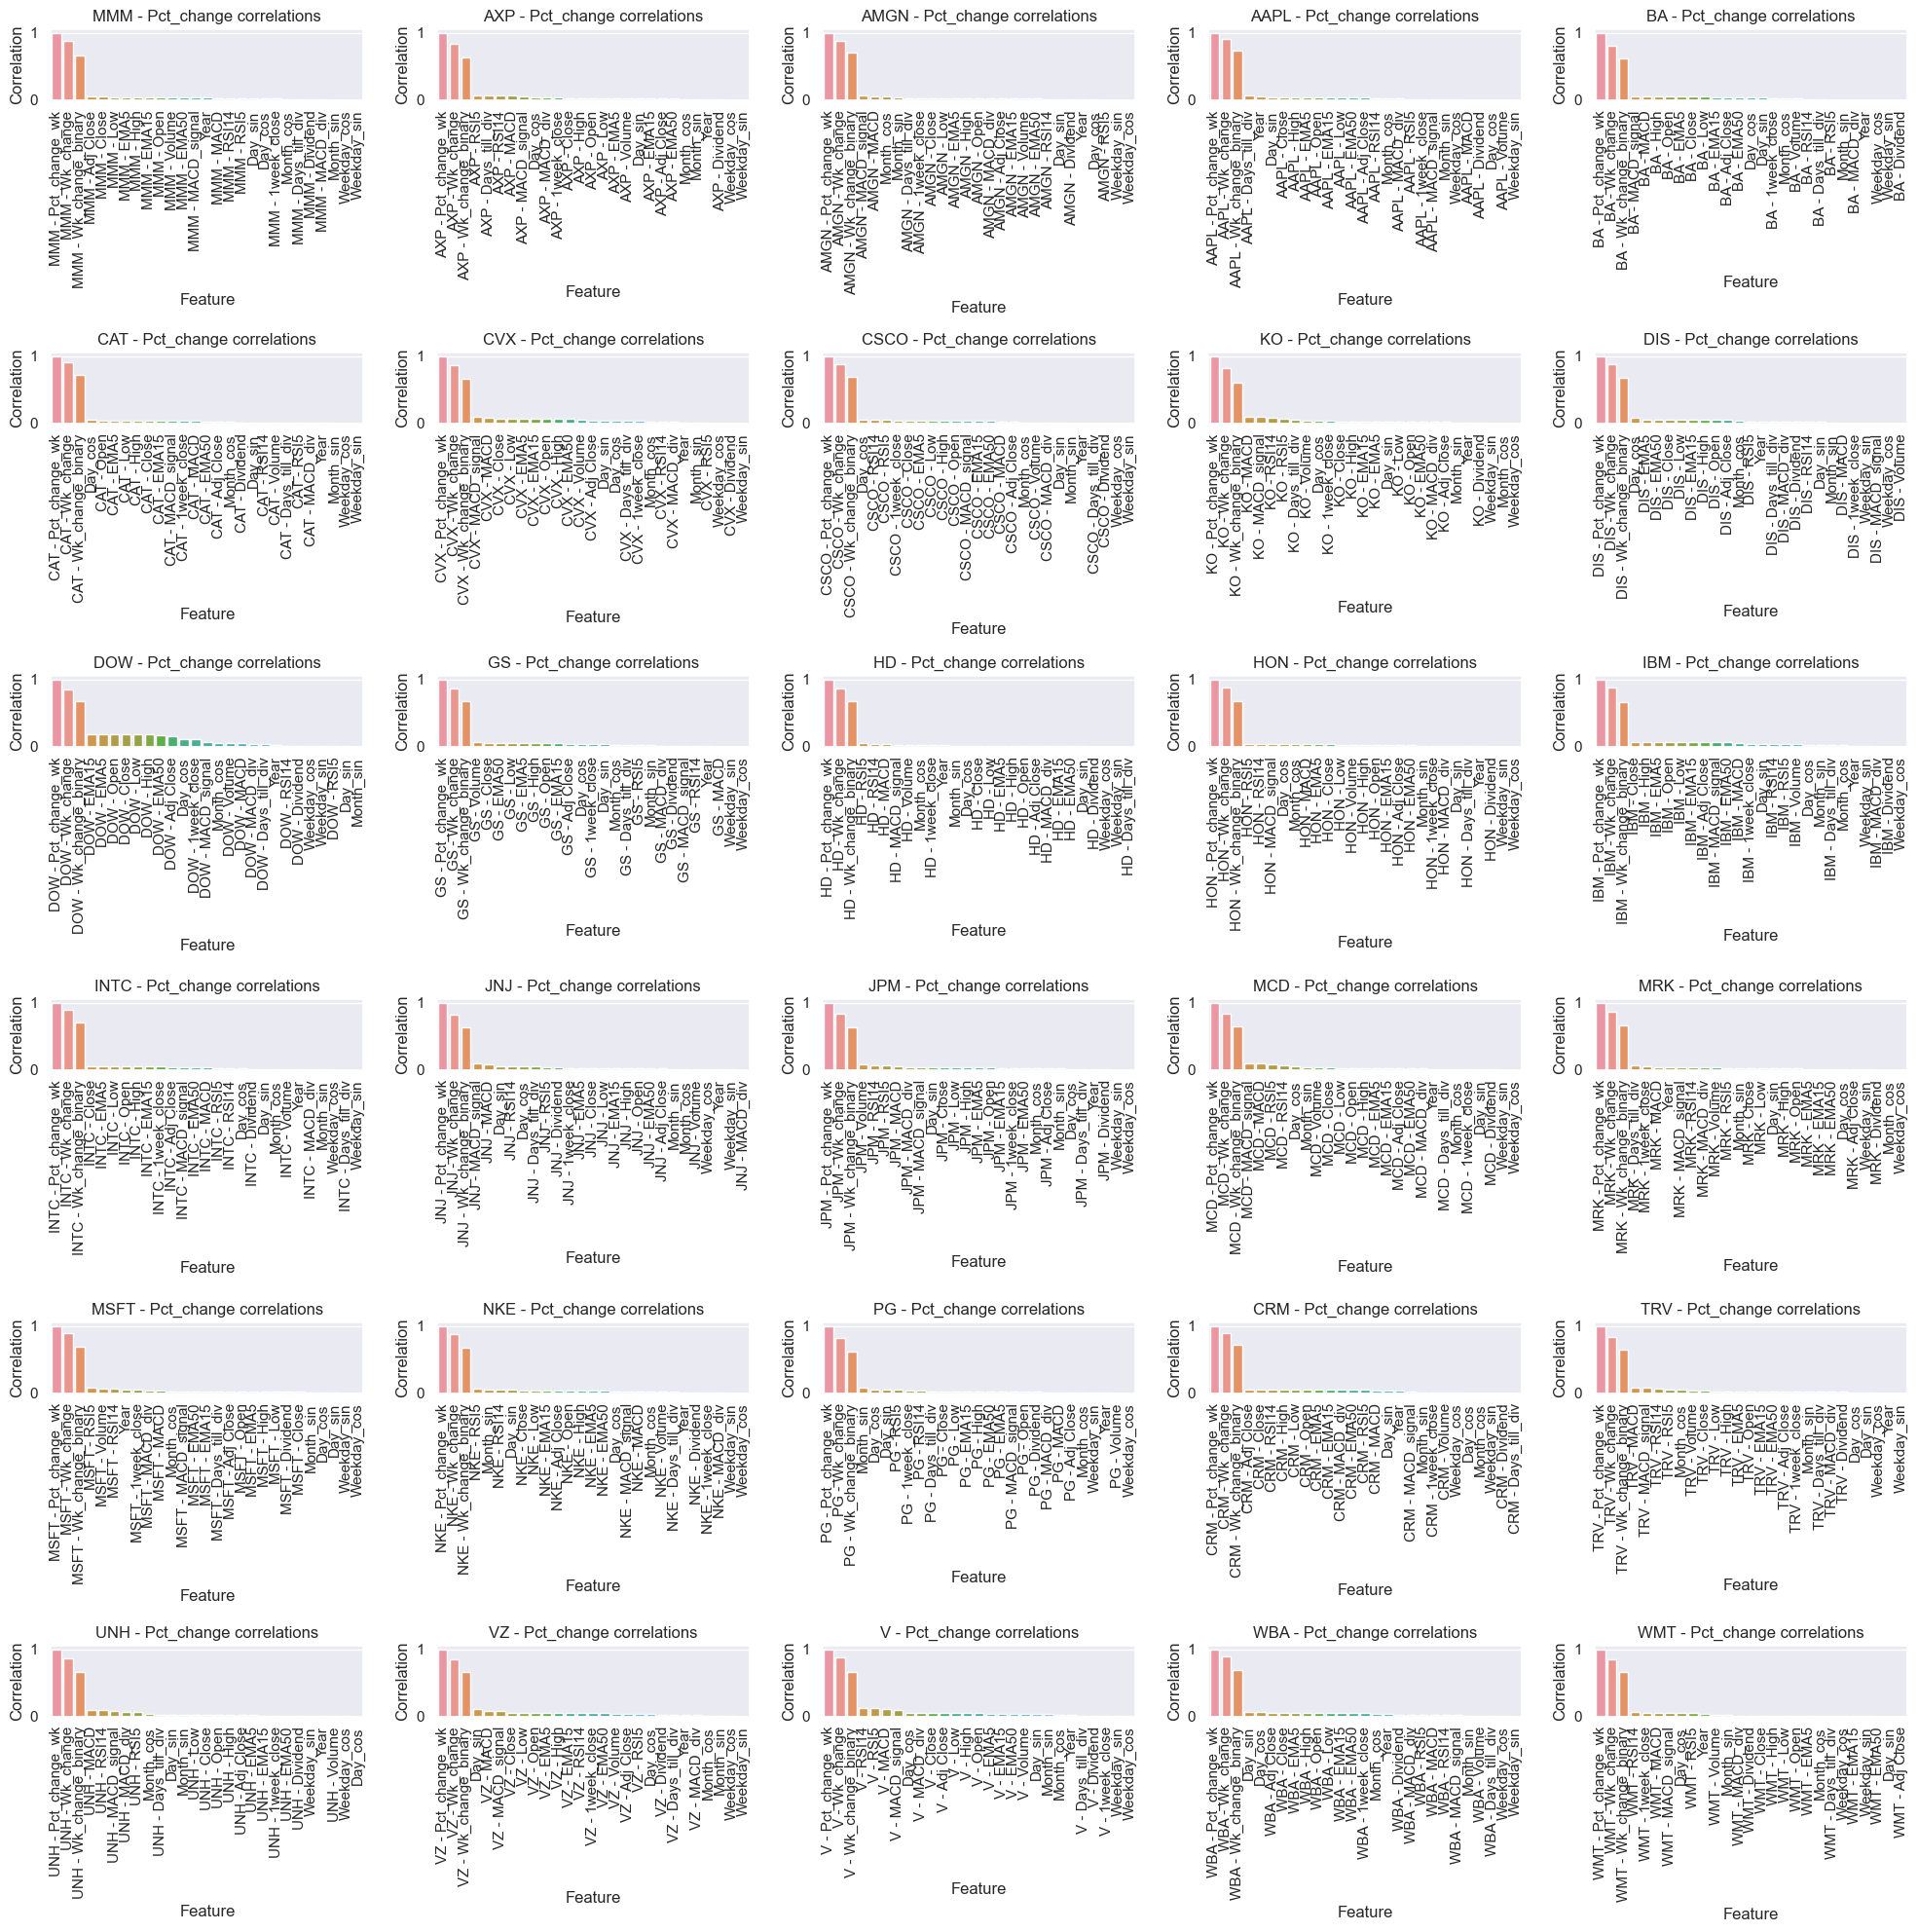

In [365]:
# Define the number of rows and columns for the grid
num_rows = 6
num_cols = 5

# Calculate the total number of subplots
total_plots = num_rows * num_cols

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# Iterate over the stocks and create subplots
for i, stock in enumerate(listings[:total_plots]):
    target = f'{stock} - Pct_change'
    # Calculate the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols
    
    # Select the corresponding axis for the current subplot
    ax = axes[row, col]
    
    # Plot the data on the current subplot
    sns.barplot(x=correlation_table[i].index, y=correlation_table[i].values, ax=ax)
    ax.set_title(f'{target} correlations')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Correlation')
    
    # Format x-axis ticks
    ax.tick_params(axis='x', rotation=90, size=4)
    
# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

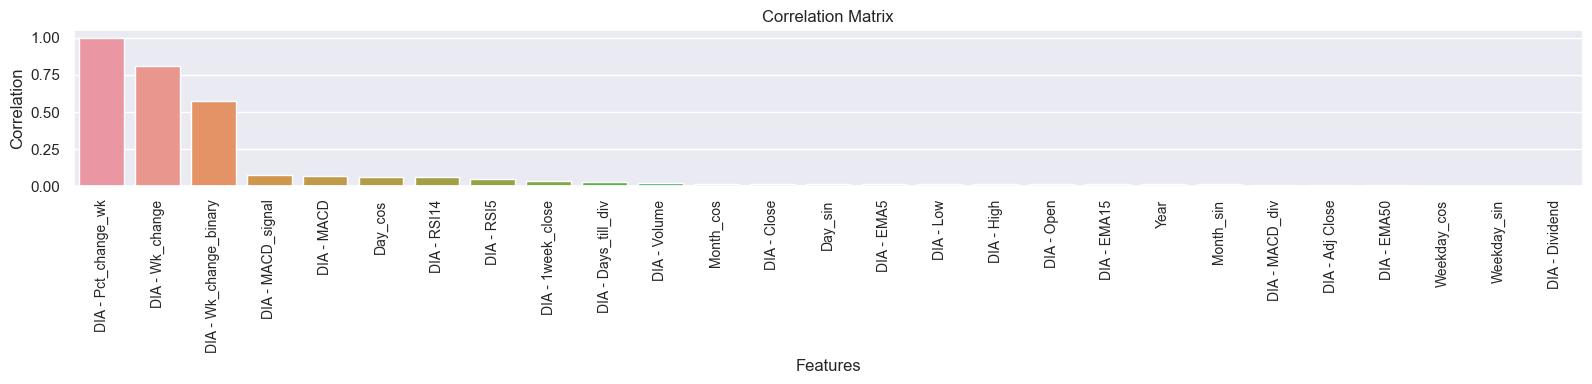

In [366]:
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.title("Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## Plottings

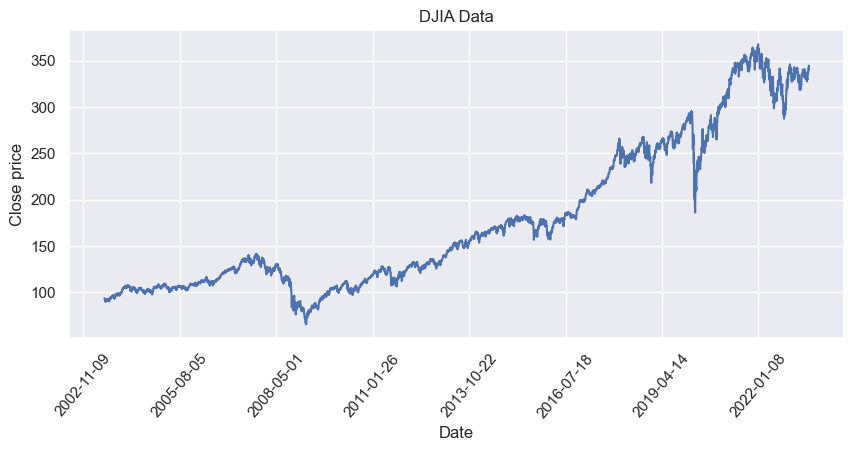

In [367]:
x = mdates.date2num(df['Date'])

sns.set(rc={'figure.figsize':(10, 4)})
sns.lineplot(x=x, y=df['DIA - Close'])

plt.title('DJIA Data')
plt.xlabel('Date')
plt.ylabel('Close price')

date_form = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_form)
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=50)
plt.show()

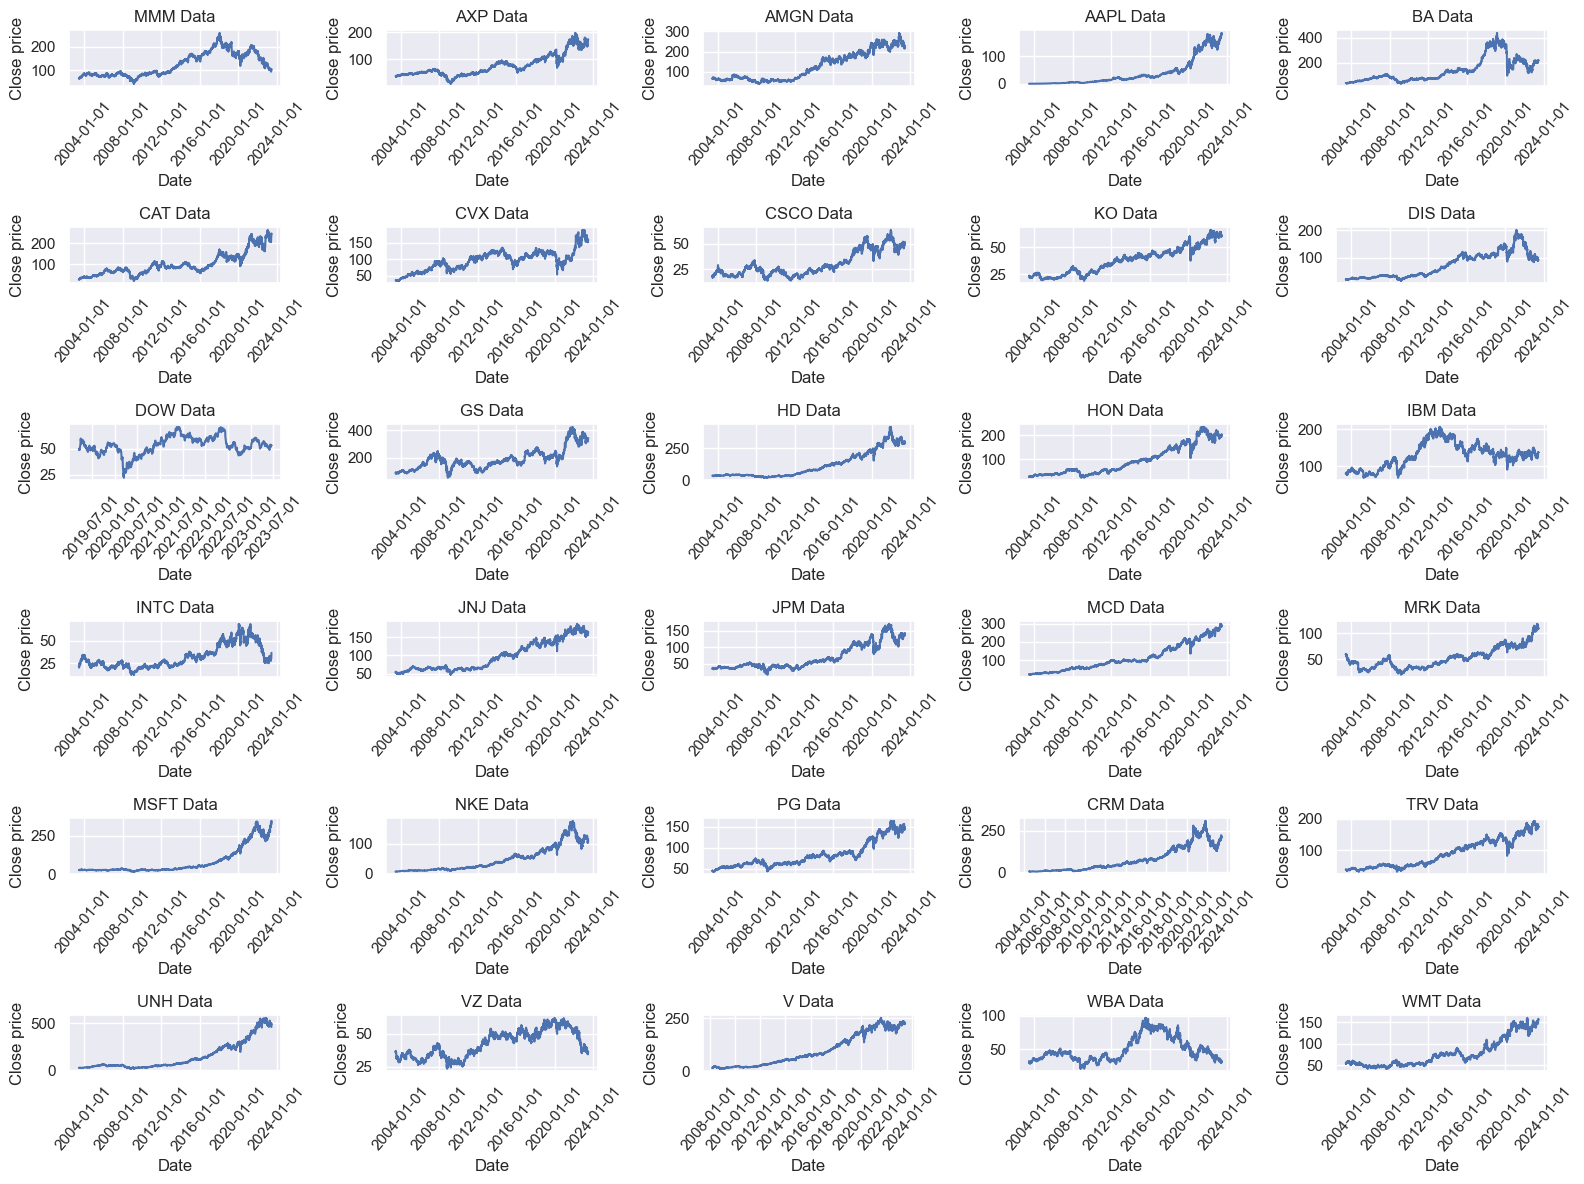

In [368]:
# Define the number of rows and columns for the grid
num_rows = 6
num_cols = 5

# Calculate the total number of subplots
total_plots = num_rows * num_cols

x = mdates.date2num(df['Date'])

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

# Iterate over the stocks and create subplots
for i, stock in enumerate(listings[:total_plots]):
    # Calculate the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols
    
    # Select the corresponding axis for the current subplot
    ax = axes[row, col]
    
    # Plot the data on the current subplot
    sns.lineplot(x=x, y=df[f'{stock} - Close'], ax=ax)
    ax.set_title(f'{stock} Data')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close price')
    
    # Format x-axis ticks
    date_form = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='x', rotation=50)
    
# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

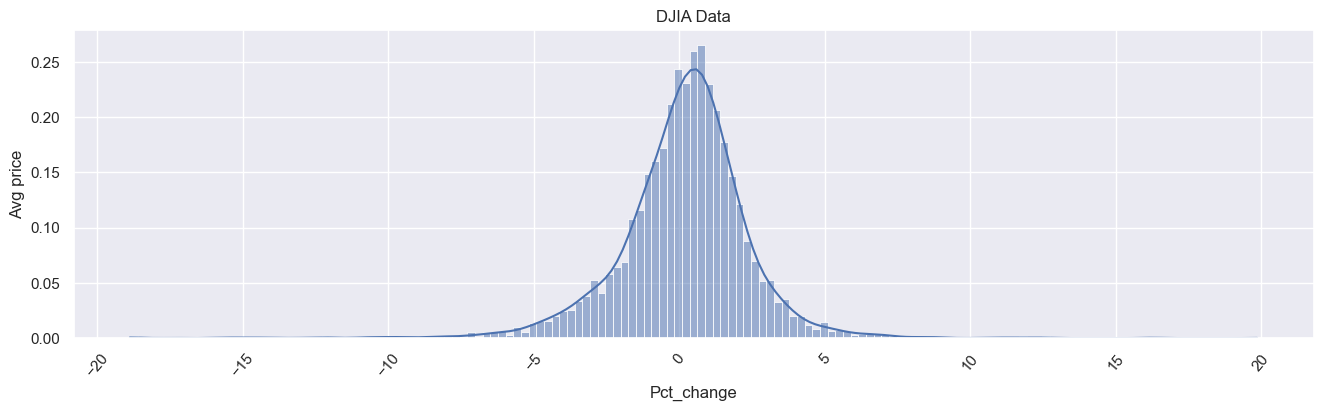

In [369]:
sns.set(rc={'figure.figsize':(16, 4)})
sns.histplot(df['DIA - Pct_change_wk'], stat = 'density', kde=True)

plt.title('DJIA Data')
plt.xlabel('Pct_change')
plt.ylabel('Avg price')

plt.xticks(rotation=50)
plt.show()

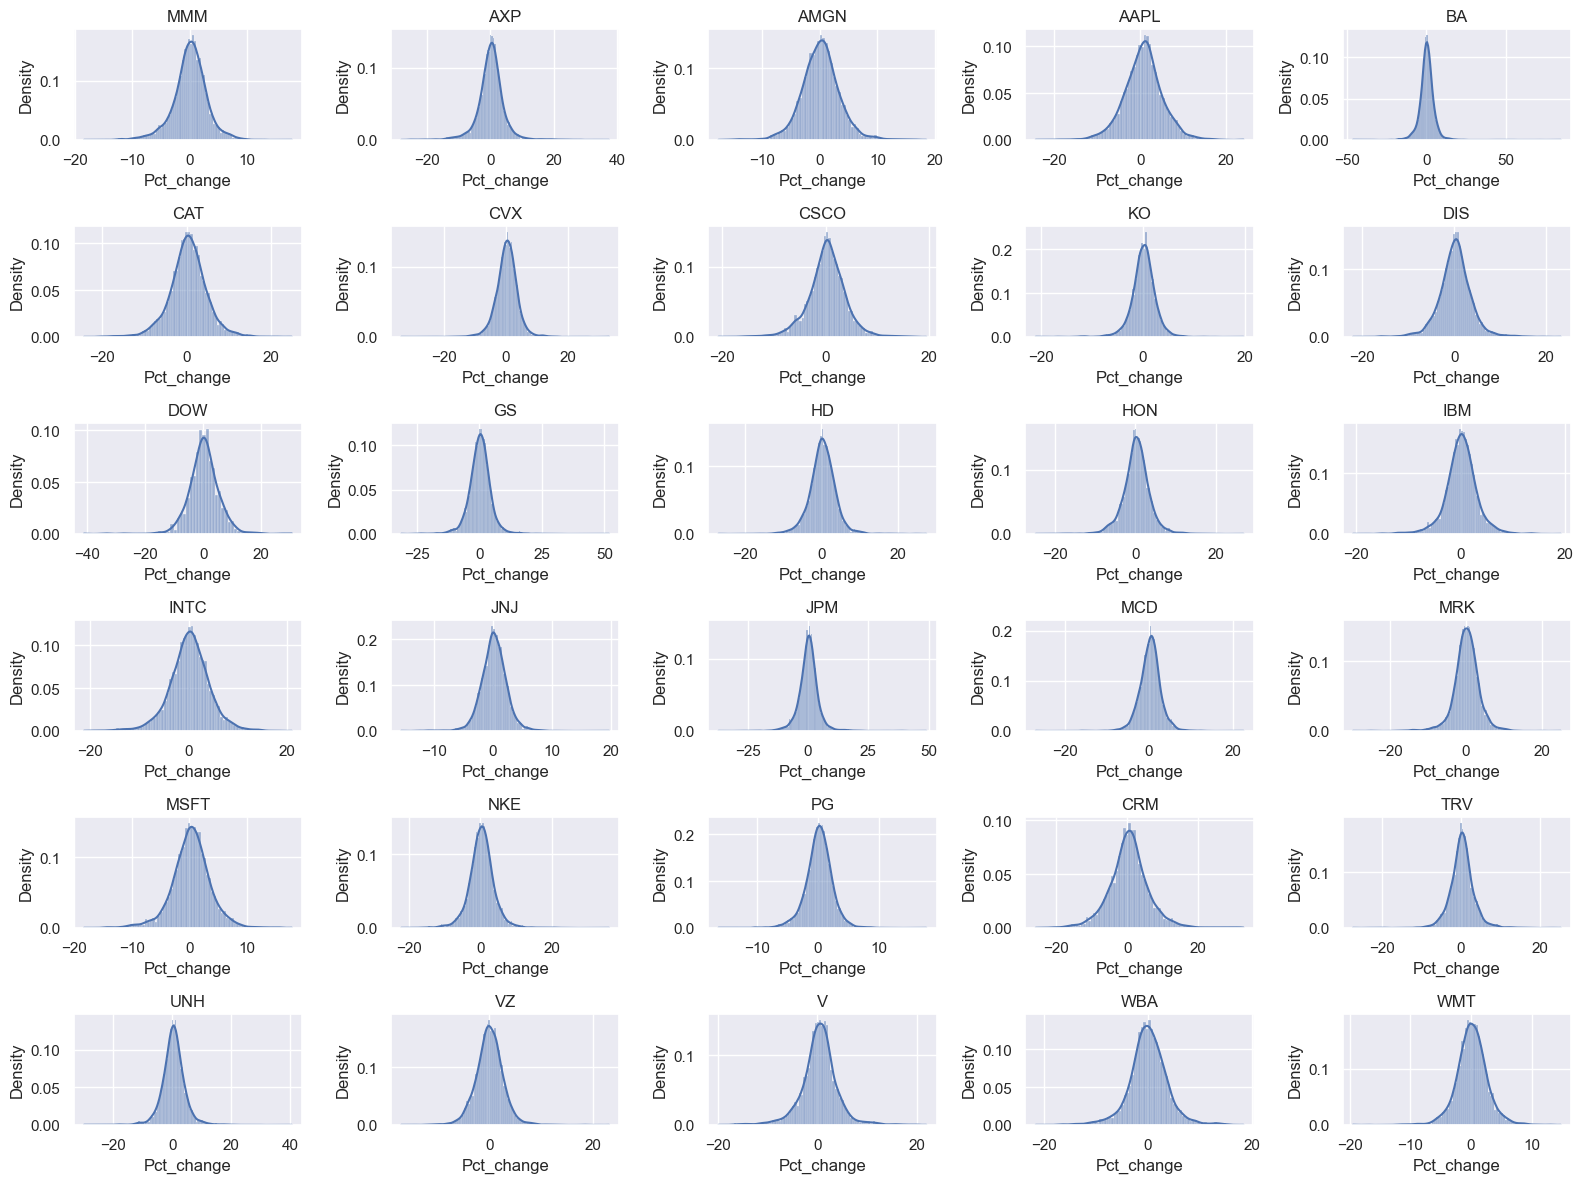

In [370]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

# Iterate over the stocks and create subplots
for i, stock in enumerate(listings[:total_plots]):
    # Calculate the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols
    
    # Select the corresponding axis for the current subplot
    ax = axes[row, col]
    
    sns.histplot(df[f'{stock} - Pct_change_wk'], stat='density', kde=True, ax=ax)
    ax.set_title(f'{stock}')
    ax.set_xlabel('Pct_change')
    ax.set_ylabel('Density')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

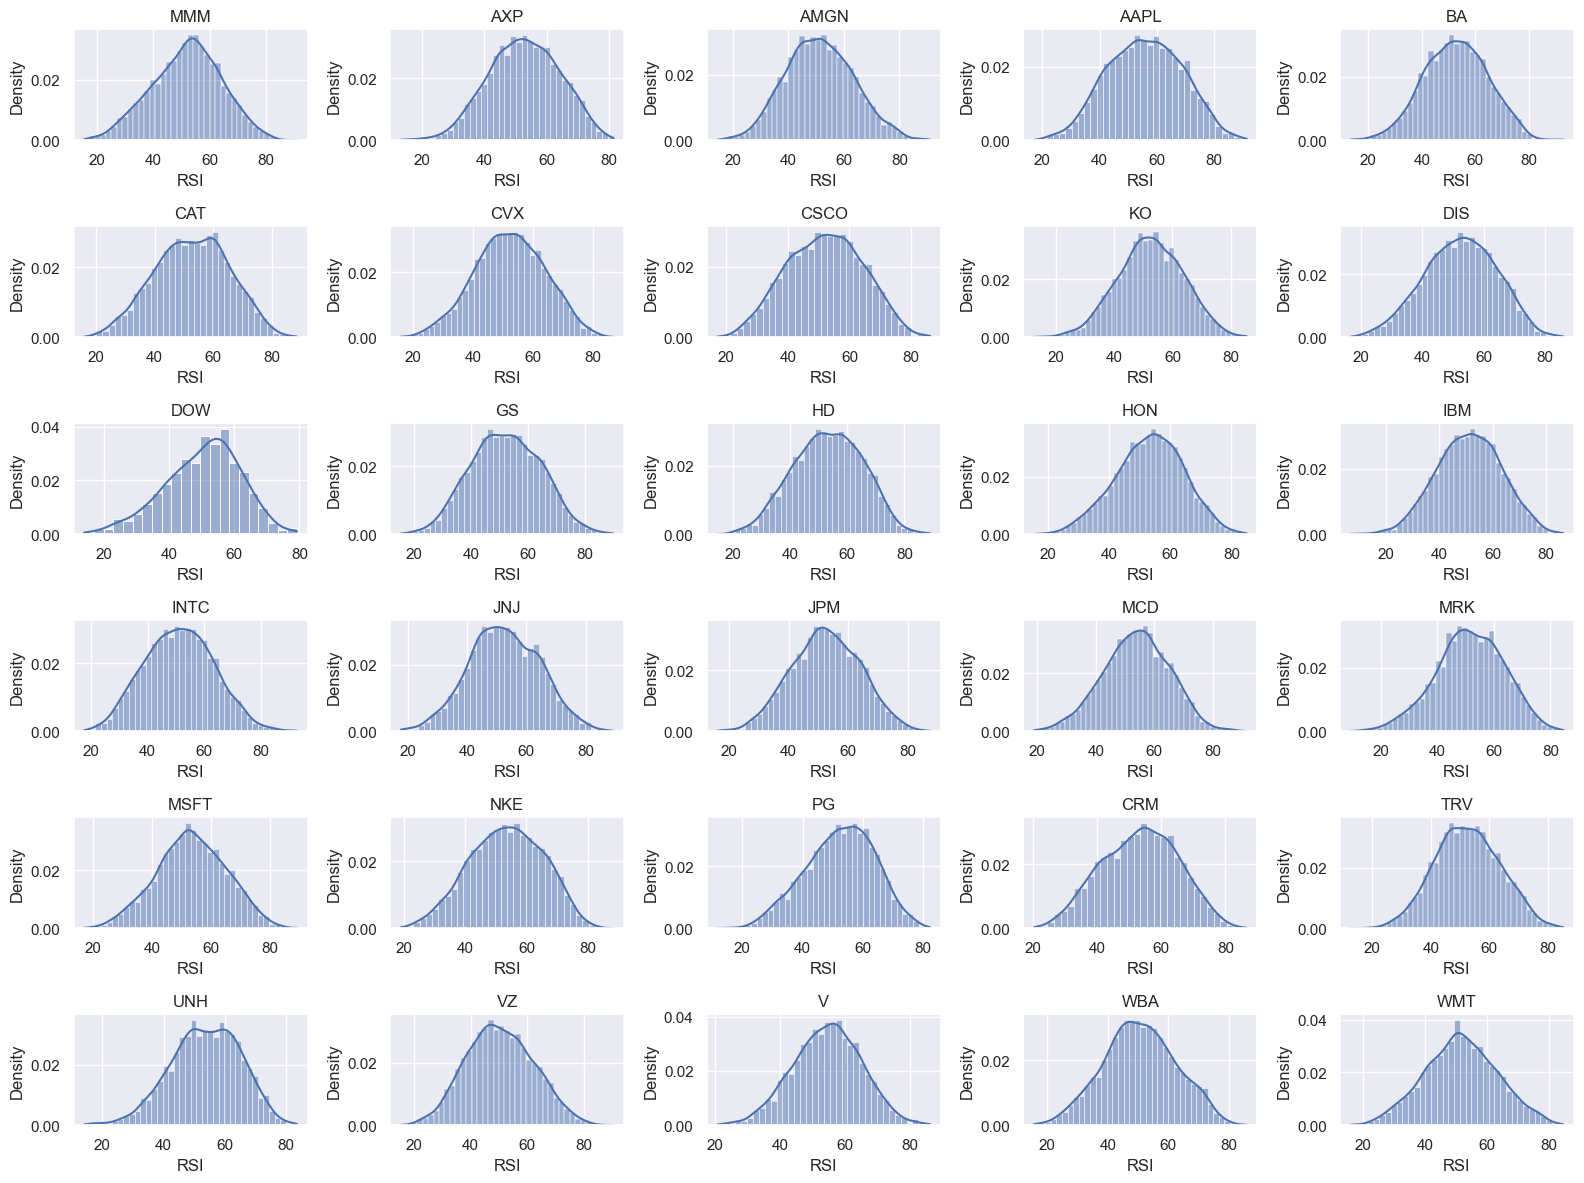

In [371]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

# Iterate over the stocks and create subplots
for i, stock in enumerate(listings[:total_plots]):
    # Calculate the row and column indices for the current subplot
    row = i // num_cols
    col = i % num_cols
    
    # Select the corresponding axis for the current subplot
    ax = axes[row, col]
    
    sns.histplot(df[f'{stock} - RSI14'], stat='density', kde=True, ax=ax)
    ax.set_title(f'{stock}')
    ax.set_xlabel('RSI')
    ax.set_ylabel('Density')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

# LSTM - Regression

## Imports and performance reporting functions

In [372]:
def rmse_calc(y_true, y_pred):
    """
    Function to calculate RMSE
    Inputs: y_true - True target values
            y_pred - Predicted target values
    Returns: RMSE
    """
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def mape_calc(y_true, y_pred):
    """
    Function to calculate MAPE
    Inputs: y_true - True target values
            y_pred - Predicted target values
    Returns: MAPE
    """    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

In [373]:
def x_scaling(train, test, scaling_features):
    """
    Function to scale target features in training and testing dataset and recombine with unscaled features
    Inputs: train - Training dataset
            test - Testing dataset
            scaling_features - Features which will be scaled in the training and testing datasets
    Returns: train_scaled - Training dataset with desired features scaled
             test_scaled - Testing dataset with desired features fit to training scaling
    """
    scaler = MinMaxScaler()
    
    scaling_train_fts = train[scaling_features]
    scaling_test_fts = test[scaling_features]
    non_scaling_train = train.drop(columns = scaling_features)
    non_scaling_test = test.drop(columns = scaling_features)

    train_scaled = scaler.fit_transform(scaling_train_fts)
    test_scaled = scaler.transform(scaling_test_fts)

    train_scaled = np.concatenate((train_scaled, non_scaling_train), axis=1)
    test_scaled = np.concatenate((test_scaled, non_scaling_test), axis=1)

    return train_scaled, test_scaled

In [374]:
def train_test_split_time_series(x, y, size):
    """
    Function to create a train test split for time series data
    Inputs: x - Input features for model
            y - Target for model
            size - Percentage of dataset for training split
    Returns: x_train - Input features for training split
             x_test - Input features for testing split
             y_train - Target for training split
             y_test - Target for testing split
    """
    split = int(len(x)*size)
    y = y.values.reshape(-1,1)
    x_train, x_test = x[:split], x[split:]
    y_train, y_test = y[:split], y[split:]

    return x_train, x_test, y_train, y_test

In [375]:
def sequencing(x_train, x_test, y_train, y_test, timesteps):
    """
    Function to create a sequence of features and targets for a time series prediction using LSTM
    Inputs: x_train - Input features for training dataset
            x_test - Input features for testing dataset
            y_train - Target for training dataset
            y_test - Target for testing dataset
            timesteps - The length of time for each sequence of features and targets
    Returns: x_train_lstm - Array of sequenced input training data
             x_test_lstm - Array of sequenced input testing data
             y_train_lstm - Array of sequenced target training data
             y_test_lstm - Array of sequenced target testing data
    """
    x_train_lstm = []
    x_test_lstm = []

    for i in range(x_train[0].size):
        x_train_lstm.append([])
        x_test_lstm.append([])
        for j in range(timesteps, x_train.shape[0]):
            x_train_lstm[i].append(x_train[j-timesteps:j, i])
        for j in range(timesteps, x_test.shape[0]):
            x_test_lstm[i].append(x_test[j-timesteps:j, i])

    x_train_lstm = np.moveaxis(x_train_lstm, [0], [2])
    x_test_lstm = np.moveaxis(x_test_lstm, [0], [2])

    y_train_lstm = np.array(y_train[timesteps:,-1])
    y_test_lstm = np.array(y_test[timesteps:,-1])

    y_train_lstm = y_train_lstm.reshape(len(y_train_lstm),1)
    y_test_lstm = y_test_lstm.reshape(len(y_test_lstm),1)

    return x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm

## Data setup

In [421]:
# identify stock of interest, features, and target
stock = 'AAPL'
target = [f'{stock} - Pct_change_wk']

# remove any nan rows existing in dataset due to creation of technical indicators
cols_to_check = [f'{stock} - EMA50'] + target
modeling_df = df.dropna(subset=cols_to_check)

cyclic_fts = ['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Weekday_sin', 'Weekday_cos']
numerical_fts = [f'{stock} - Dividend', f'{stock} - Close', f'{stock} - Volume', 'Year', f'{stock} - RSI14', f'{stock} - RSI5', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50', f'{stock} - MACD', f'{stock} - MACD_signal']
all_fts = ['Date'] + cyclic_fts + numerical_fts

### Train test split

In [422]:
# train test split
x = modeling_df[all_fts]
y = modeling_df[target]

x_train, x_test, y_train, y_test = train_test_split_time_series(x, y, .8)

# store split dates for future plotting
train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop(columns=['Date'])
x_train = x_train.drop(columns=['Date'])

# feature scaling
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)

# scale target
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# sequence training and testing data
x_train_seq, x_test_seq, y_train_seq, y_test_seq = sequencing(x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, 21)

# sequence dates of training and testing data
train_dates_seq = np.array(train_dates[21:])
test_dates_seq = np.array(test_dates[21:])

### Modeling

In [423]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('32_nodes.h5', monitor='val_loss', save_best_only=True)
model = Sequential()
model.add(LSTM(32, input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_seq, y_train_seq, epochs=1000, batch_size=32, validation_data=(x_test_seq, y_test_seq), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000
124/124 - 2s - loss: 0.0373 - val_loss: 0.0146 - 2s/epoch - 17ms/step
Epoch 2/1000
124/124 - 1s - loss: 0.0190 - val_loss: 0.0103 - 526ms/epoch - 4ms/step
Epoch 3/1000
124/124 - 1s - loss: 0.0161 - val_loss: 0.0101 - 517ms/epoch - 4ms/step
Epoch 4/1000
124/124 - 1s - loss: 0.0147 - val_loss: 0.0160 - 518ms/epoch - 4ms/step
Epoch 5/1000
124/124 - 1s - loss: 0.0136 - val_loss: 0.0155 - 505ms/epoch - 4ms/step
Epoch 6/1000
124/124 - 1s - loss: 0.0125 - val_loss: 0.0161 - 543ms/epoch - 4ms/step
Epoch 7/1000
124/124 - 1s - loss: 0.0123 - val_loss: 0.0158 - 521ms/epoch - 4ms/step
Epoch 8/1000
124/124 - 1s - loss: 0.0121 - val_loss: 0.0173 - 512ms/epoch - 4ms/step
Epoch 9/1000
124/124 - 1s - loss: 0.0117 - val_loss: 0.0187 - 505ms/epoch - 4ms/step
Epoch 10/1000
124/124 - 1s - loss: 0.0116 - val_loss: 0.0173 - 518ms/epoch - 4ms/step
Epoch 11/1000
124/124 - 1s - loss: 0.0116 - val_loss: 0.0153 - 513ms/epoch - 4ms/step
Epoch 12/1000
124/124 - 1s - loss: 0.0111 - val_loss: 0.0180 - 50

In [424]:
best_model = load_model('32_nodes.h5')
y_pred = best_model.predict(x_test_seq)

31/31 [==============================] - 0s 1ms/step


In [425]:
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

mse = np.mean((y_pred_inv - y_test_inv)**2)

print('LSTM Scores')
print(f'MSE:  {mse:.3f}')
print(f'MAE:  {mean_absolute_error(y_test_inv, y_pred_inv):.3f}')
print(f'RMSE: {rmse_calc(y_test_inv, y_pred_inv):.3f}')
print(f'MAPE: {mape_calc(y_test_inv, y_pred_inv):.3f}')

LSTM Scores
MSE:  23.722
MAE:  3.869
RMSE: 4.871
MAPE: 2.963


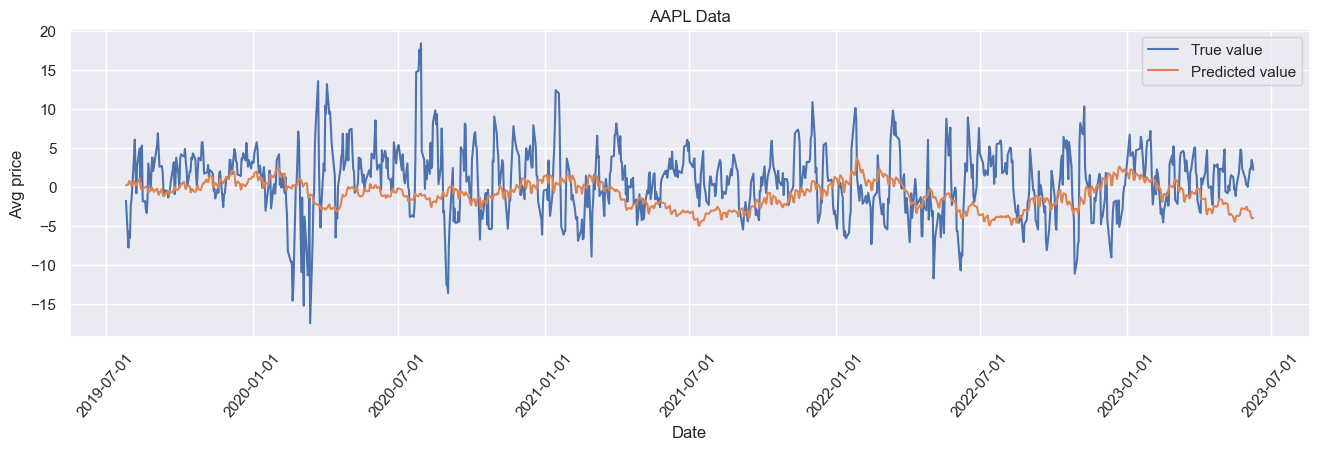

In [426]:
x = mdates.date2num(test_dates_seq)

sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=x, y=y_test_inv.flatten(), label=f'True value')
sns.lineplot(x=x, y=y_pred_inv.flatten(), label=f'Predicted value')

plt.title(f'{stock} Data')
plt.xlabel('Date')
plt.ylabel('Avg price')


date_form = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_form)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=50)
plt.show()

# LSTM Binary Classification

In [427]:
# identify stock of interest, features, and target
stock = 'MMM'
target = [f'{stock} - Wk_change_binary']

# remove any nan rows existing in dataset due to creation of technical indicators
cols_to_check = [f'{stock} - EMA50'] + target
modeling_df = df.dropna(subset=cols_to_check)

cyclic_fts = ['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Weekday_sin', 'Weekday_cos']
numerical_fts = [f'{stock} - Days_till_div', f'{stock} - Close', f'{stock} - Volume', 'Year', f'{stock} - RSI5', f'{stock} - RSI14', f'{stock} - EMA5', f'{stock} - EMA15', f'{stock} - EMA50']
all_fts = ['Date', 'Day', 'Month'] + numerical_fts #+ cyclic_fts 

### Train test split

In [428]:
# train test split
x = modeling_df[all_fts]
y = modeling_df[target]

x_train, x_test, y_train, y_test = train_test_split_time_series(x, y, .8)

# store split dates for future plotting
train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop(columns=['Date'])
x_train = x_train.drop(columns=['Date'])

# feature scaling
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)

# sequence training and testing data
x_train_seq, x_test_seq, y_train_seq, y_test_seq = sequencing(x_train_scaled, x_test_scaled, y_train, y_test, 21)

# sequence dates of training and testing data
train_dates_seq = np.array(train_dates[21:])
test_dates_seq = np.array(test_dates[21:])

### Modeling

In [429]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('classification.h5', monitor='val_loss', save_best_only=True)

model = Sequential()
model.add(LSTM(32, input_shape=(x_train_seq.shape[1], x_train_seq.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall(), AUC()])

history = model.fit(x_train_seq, y_train_seq, epochs=1000, batch_size=32, validation_data=(x_test_seq, y_test_seq), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000
124/124 - 2s - loss: 0.5513 - accuracy: 0.7724 - precision_4: 0.2647 - recall_4: 0.0207 - auc_4: 0.4943 - val_loss: 0.5585 - val_accuracy: 0.7544 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5993 - 2s/epoch - 17ms/step
Epoch 2/1000
124/124 - 0s - loss: 0.5369 - accuracy: 0.7797 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5116 - val_loss: 0.5614 - val_accuracy: 0.7544 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5938 - 419ms/epoch - 3ms/step
Epoch 3/1000
124/124 - 0s - loss: 0.5347 - accuracy: 0.7802 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5193 - val_loss: 0.5618 - val_accuracy: 0.7544 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_auc_4: 0.5648 - 415ms/epoch - 3ms/step
Epoch 4/1000
124/124 - 0s - loss: 0.5337 - accuracy: 0.7802 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5162 - val_loss: 0.5619 - val_accuracy: 0.7544 - val_precision_4: 0.0000e+00 - val_

In [430]:
loss, accuracy, precision, recall, auc = model.evaluate(x_test_seq, y_test_seq)

31/31 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7544 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.5368


In [431]:
def perf_metrics(y_test, y_pred, model, dataset):
    """Function to calculate and return performance metrics"""
    metrics = {
        'Model': model,
        'Stock': dataset,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred)
    }
    return metrics

# df to store perf metrics thru rest of nb
metrics_df = pd.DataFrame()

In [432]:
dt = DecisionTreeClassifier()
dt = dt.fit(x_train_scaled, y_train)

In [433]:
# predict on classifier
y_pred = dt.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'DT', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [434]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [435]:
# predict on classifier
y_pred = gbt.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'GBT', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [436]:
# create and fit RF
rf = RandomForestClassifier()
rf = rf.fit(x_train_scaled, y_train)

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_2856\3149677526.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(x_train_scaled, y_train)


In [437]:
# predict on classifier
y_pred = rf.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'RF', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [438]:
svm = SVC()
svm = svm.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [439]:
y_pred = svm.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'SVM', stock)
metrics_df = metrics_df.append(metrics, ignore_index=True)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [440]:
importances = gbt.feature_importances_
fn = x_train.columns

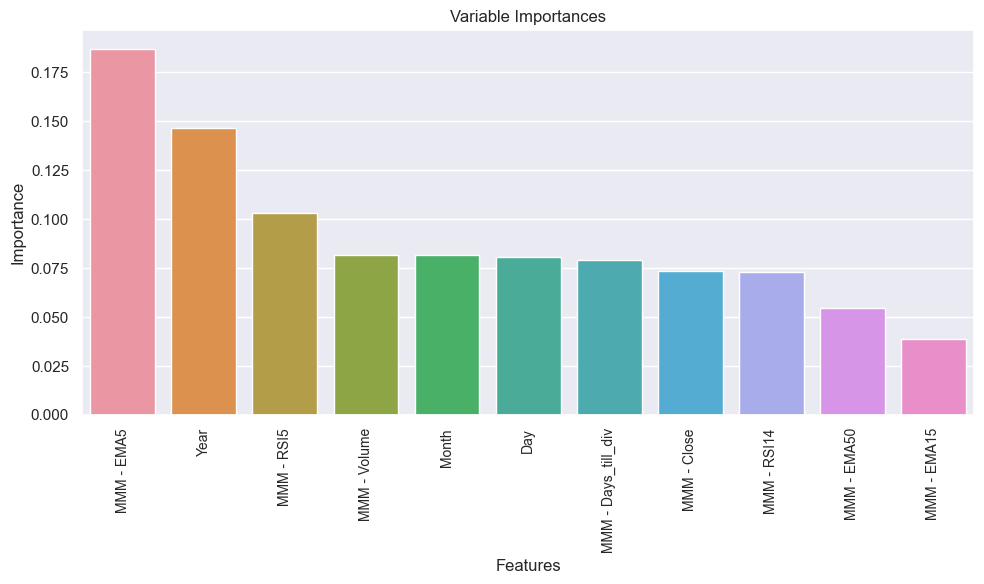

In [441]:
# sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in indices]
sorted_fn = [fn[idx] for idx in indices]

# plot the variable importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_fn, y=sorted_importances)
plt.title("Variable Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# All stocks in one classification model

In [442]:
test_df = df.copy()

In [443]:
combined_df = pd.DataFrame()

for stock in listings:
    temp_df = pd.DataFrame()
    stock_cols = [col for col in test_df.columns if col.startswith(f'{stock} -')]
    for col in stock_cols:
        new_col_name = col.replace(f'{stock} - ', '')
        temp_df[new_col_name] = test_df[col]
    universal_cols = [col for col in test_df.columns if '-' not in col]
    temp_df[universal_cols] = test_df[universal_cols]
    combined_df = pd.concat([temp_df, combined_df], ignore_index=True)

In [444]:
combined_df = combined_df.dropna()

In [445]:
combined_df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Dividend',
       'RSI14', 'RSI5', 'EMA5', 'EMA15', 'EMA50', 'MACD', 'MACD_signal',
       'MACD_div', '1week_close', 'Pct_change_wk', 'Wk_change_binary',
       'Wk_change', 'Days_till_div', 'Date', 'Year', 'Month', 'Day', 'Weekday',
       'Weekday_sin', 'Weekday_cos', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos'],
      dtype='object')

In [446]:
# identify stock of interest, features, and target
target = ['Wk_change_binary']

cyclic_fts = ['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Weekday_sin', 'Weekday_cos']
numerical_fts = ['Days_till_div', 'Close', 'Volume', 'RSI5', 'RSI14', 'EMA5', 'EMA15', 'EMA50', 'MACD', 'MACD_signal']
all_fts = ['Day', 'Month', 'Year'] + numerical_fts #+ cyclic_fts 

In [447]:
len(combined_df)

149128

In [448]:
len(combined_df[combined_df['Date'] > '2021-06-30'])

15159

In [449]:
training_df = combined_df.drop(combined_df[combined_df['Date'] > '2021-06-30'].index)
testing_df = combined_df.drop(combined_df[combined_df['Date'] < '2021-07-01'].index)

In [450]:
# train test split
x = training_df[all_fts]
y = training_df[target]

x_test = testing_df[all_fts]
y_test = testing_df[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.1)

# feature scaling
x_train_scaled, x_test_scaled = x_scaling(x_train, x_test, numerical_fts)
x_train_scaled, x_val_scaled = x_scaling(x_train, x_val, numerical_fts)

## Modeling

In [451]:
dt = DecisionTreeClassifier()
dt = dt.fit(x_train_scaled, y_train)

In [452]:
# predict on classifier
y_pred = dt.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'DT', 'Testing')
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [453]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(x_train_scaled, y_train)

c:\Users\Reed Oken\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [454]:
# predict on classifier
y_pred = gbt.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'GBT', 'Testing')
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [455]:
# create and fit RF
rf = RandomForestClassifier()
rf = rf.fit(x_train_scaled, y_train)

C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_2856\3149677526.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(x_train_scaled, y_train)


In [456]:
# predict on classifier
y_pred = rf.predict(x_test_scaled)

metrics = perf_metrics(y_test, y_pred, 'RF', 'Testing')
metrics_df = metrics_df.append(metrics, ignore_index=True)

In [457]:
#svm = SVC()
#svm = svm.fit(x_train_scaled, y_train)

In [458]:
#y_pred = svm.predict(x_test_scaled)

#metrics = perf_metrics(y_test, y_pred, 'SVM', stock)
#metrics_df = metrics_df.append(metrics, ignore_index=True)

In [459]:
metrics_df[metrics_df['Model'] == 'DT'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
0,DT,MMM,0.594,0.254,0.333,0.288,0.506
4,DT,Testing,0.578,0.285,0.395,0.331,0.519


In [460]:
metrics_df[metrics_df['Model'] == 'GBT'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
1,GBT,MMM,0.678,0.278,0.191,0.227,0.514
5,GBT,Testing,0.734,0.468,0.035,0.065,0.510


In [461]:
metrics_df[metrics_df['Model'] == 'RF'].round(3)

,Model,Stock,Accuracy,Precision,Recall,F1,AUC
2,RF,MMM,0.683,0.287,0.191,0.229,0.518
6,RF,Testing,0.698,0.352,0.169,0.228,0.528


In [462]:
print('Num preds: ', y_pred.size)
print('Neg preds: ', np.count_nonzero(y_pred == 0))
print('Pos preds: ', np.count_nonzero(y_pred == 1))

Num preds:  15159
Neg preds:  13234
Pos preds:  1925


In [463]:
print('Test size: ', y_test.size)
print('True negs: ', np.count_nonzero(y_test == 0))
print('True posi: ', np.count_nonzero(y_test == 1))

Test size:  15159
True negs:  11149
True posi:  4010


In [464]:
importances = rf.feature_importances_
fn = x_train.columns

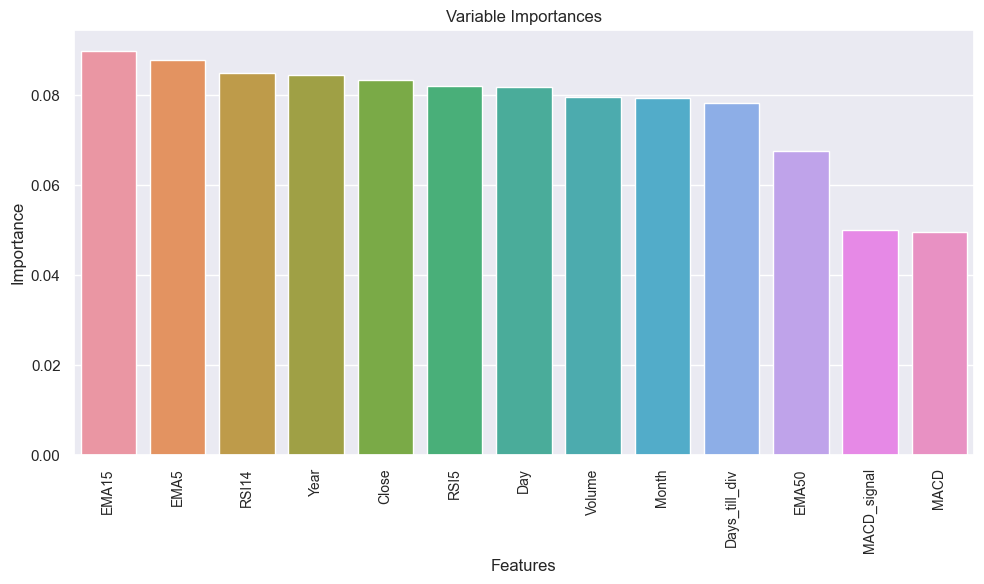

In [465]:
# sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = [importances[idx] for idx in indices]
sorted_fn = [fn[idx] for idx in indices]

# plot the variable importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_fn, y=sorted_importances)
plt.title("Variable Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()